## Loading medical image data
In this notebook, the non-scoliotic and scoliotic data for the project is showcased. This data can be used to write an algorithm to find the optimal viewing angle for clinicians using a C-arm.

In [1]:
# Library imports
import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np

from PIL import Image

## Non-scoliotic Control image data

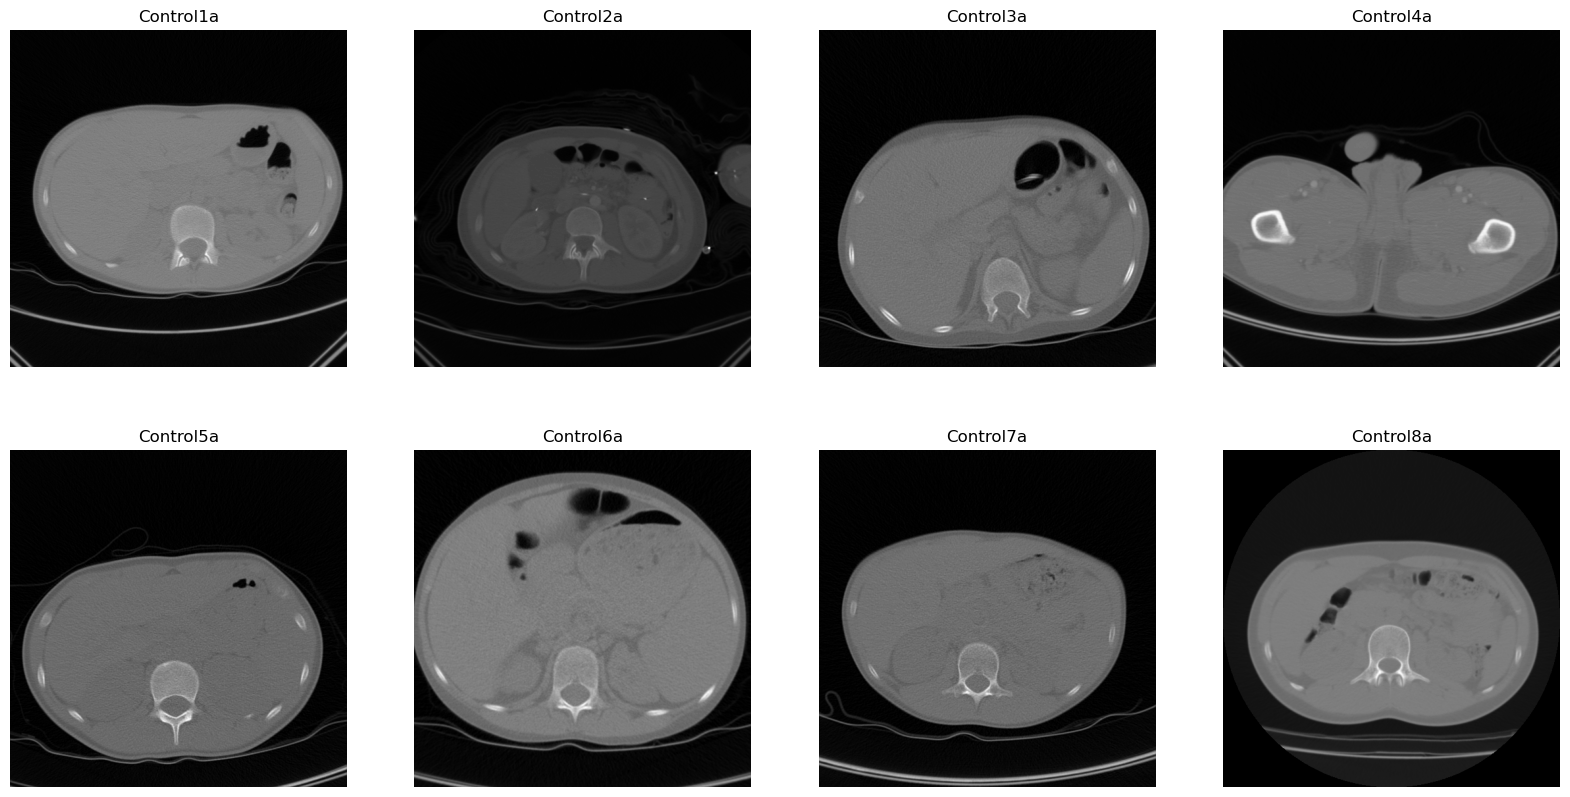

In [2]:
def plot_nonscoliotic_images():
    # Create figure with two rows and four columns
    fig, ax = plt.subplots(2, 4, figsize=(20, 10))
    ax = ax.flatten()


    # Plot Nonscoliotic image data
    for i in range(8):    
        image_path = f"data/Nonscoliotic/Control{i + 1}a.tif"
        image = np.array(Image.open(image_path))
        
        ax[i].imshow(image, cmap="gray")
        ax[i].set_title(f"Control{i + 1}a")
        ax[i].axis("off")

plot_nonscoliotic_images()

## Scoliotic image data

Shape preoperative image: (512, 512, 437)
Shape postoperative image: (512, 512, 427)


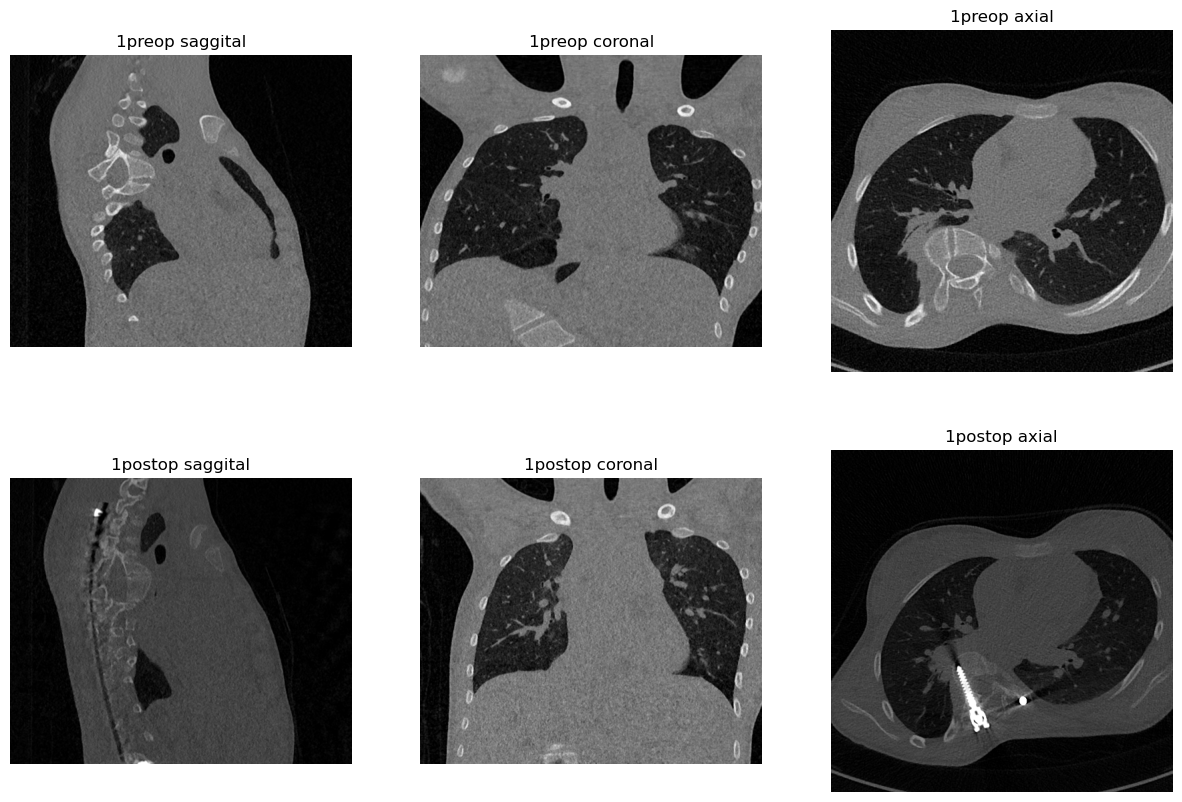

In [ ]:
def plot_scoliotic_image(image_idx, slice_idx=None):
    # Create path to NIfTI data 
    preop_image_path = f"data/Scoliose/{image_idx}preop.nii"
    postop_image_path = f"data/Scoliose/{image_idx}postop.nii" 

    # Load NIfTI data 
    preop_image = nib.load(preop_image_path).get_fdata()
    postop_image = nib.load(postop_image_path).get_fdata()
    print(f"Shape preoperative image: {preop_image.shape}")
    print(f"Shape postoperative image: {postop_image.shape}")

    # Get middle slices if slice_idx not specified
    if slice_idx is None:
        slice_idx = {
            "sagittal": preop_image.shape[0] // 2,
            "coronal": preop_image.shape[1] // 2,
            "axial": preop_image.shape[2] // 2
        }

    # Create figure with one row and two columns
    fig, ax = plt.subplots(2, 3, figsize=(15, 10))
    [axes.set_axis_off() for axes in ax.flatten()]

    # Sagittal Slice
    ax[0,0].imshow(np.rot90(preop_image[slice_idx["sagittal"],:,:]), cmap="gray")
    ax[0,0].set_title(f"{image_idx}preop saggital")
    ax[1,0].imshow(np.rot90(postop_image[slice_idx["sagittal"],:,:]), cmap="gray")
    ax[1,0].set_title(f"{image_idx}postop saggital")

    # Coronal Slice
    ax[0,1].imshow(np.rot90(preop_image[:,slice_idx["coronal"],:]), cmap="gray")
    ax[0,1].set_title(f"{image_idx}preop coronal")
    ax[1,1].imshow(np.rot90(postop_image[:,slice_idx["coronal"],:]), cmap="gray")
    ax[1,1].set_title(f"{image_idx}postop coronal")

    # Axial Slice
    ax[0,2].imshow(np.rot90(preop_image[:,:,slice_idx["axial"]]), cmap="gray")
    ax[0,2].set_title(f"{image_idx}preop axial")
    ax[1,2].imshow(np.rot90(postop_image[:,:,slice_idx["axial"]]), cmap="gray")
    ax[1,2].set_title(f"{image_idx}postop axial")

    plt.show()
plot_scoliotic_image(image_idx=1)

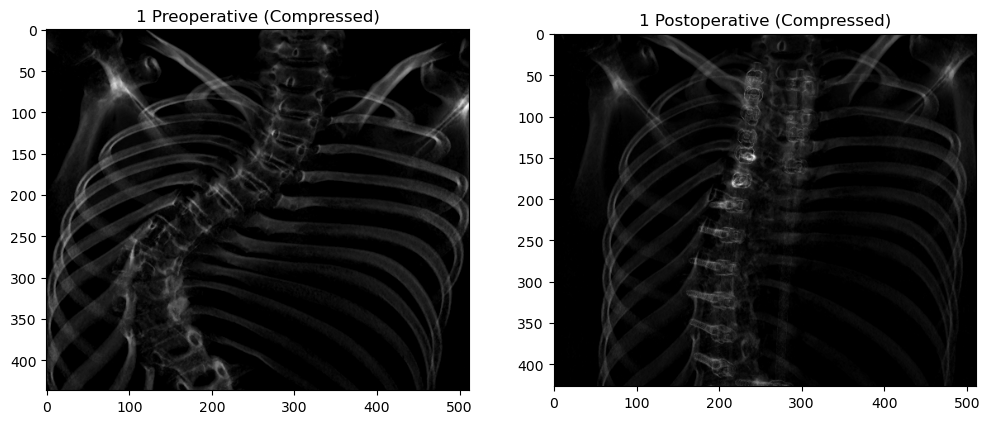

In [47]:
def plot_compressed_image(image_idx):
    import nibabel as nib
    import numpy as np
    import matplotlib.pyplot as plt

    # Load NIfTI data
    preop_image_path = f"data/Scoliose/{image_idx}preop.nii"
    postop_image_path = f"data/Scoliose/{image_idx}postop.nii"

    preop_image = nib.load(preop_image_path).get_fdata()
    postop_image = nib.load(postop_image_path).get_fdata()

    threshold_min = 500  # Lower limit
    threshold_max = 2500  # Upper limit

    # Apply thresholding (set values outside range to 0)
    binary_image_pre = np.where((preop_image >= threshold_min) & (preop_image <= threshold_max), preop_image, 0)
    binary_image_post = np.where((postop_image >= threshold_min) & (postop_image <= threshold_max), postop_image, 0)

    # Compress the 3D image to 2D using max projection
    compressed_preop = np.sum(binary_image_pre, axis=1)
    compressed_postop = np.sum(binary_image_post, axis=1)

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    ax[0].imshow(np.rot90(compressed_preop), cmap="gray")
    ax[0].set_title(f"{image_idx} Preoperative (Compressed)")
    ax[1].imshow(np.rot90(compressed_postop), cmap="gray")
    ax[1].set_title(f"{image_idx} Postoperative (Compressed)")

    plt.show()
    return compressed_preop, compressed_postop
# Example usage
preop, postop = plot_compressed_image(image_idx=1)